## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [2]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[63, 32, 16]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [24]:
import tensorflow as tf
import keras.backend as K

"""
TO DO:
Write your combined loss
"""
def combined_loss(ce_w):
    """Define the customized loss."""    
    def focal_loss_fixed(y_true, y_pred,gamma=2., alpha=4.):
        gamma = float(gamma)
        alpha = float(alpha)
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        print(alpha)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

    def ce_loss(y_true, y_pred, alpha=4.):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, tf.multiply(alpha, -tf.log(model_out)))
        return ce
    
    f1 = tf.multiply(tf.subtract(1.,ce_w), focal_loss_fixed)
    f2 = tf.multiply(ce_w, focal_loss_fixed)
    combined_loss = tf.add(f1, f2)
    return combined_loss
        
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [25]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)
    """
    TO DO:
    Compile your model with customized loss
    """

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 63)                193599    
_________________________________________________________________
batch_normalization_22 (Batc (None, 63)                252       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 32)                2048      
_________________________________________________________________
batch_normalization_23 (Batc (None, 32)                128       
_________________________________________________________________
hidden_layer3 (Dense)        (None, 16)                528       
_________________________________________________________________
batch_normalization_24 (Batc (None, 16)  

50000/50000 [==============================] - 5s 108us/step - loss: 4.0400 - acc: 0.4633 - val_loss: 4.3704 - val_acc: 0.4376
Epoch 10/25
50000/50000 [==============================] - 5s 109us/step - loss: 3.9682 - acc: 0.4684 - val_loss: 4.4125 - val_acc: 0.4346
Epoch 11/25
50000/50000 [==============================] - 5s 110us/step - loss: 3.9014 - acc: 0.4757 - val_loss: 4.3913 - val_acc: 0.4371
Epoch 12/25
50000/50000 [==============================] - 6s 122us/step - loss: 3.8424 - acc: 0.4810 - val_loss: 4.4215 - val_acc: 0.4308
Epoch 13/25
50000/50000 [==============================] - 6s 117us/step - loss: 3.7944 - acc: 0.4858 - val_loss: 4.3069 - val_acc: 0.4380
Epoch 14/25
50000/50000 [==============================] - 4s 90us/step - loss: 3.7362 - acc: 0.4908 - val_loss: 4.2953 - val_acc: 0.4413
Epoch 15/25
50000/50000 [==============================] - 4s 87us/step - loss: 3.6896 - acc: 0.4942 - val_loss: 4.2164 - val_acc: 0.4473
Epoch 16/25
50000/50000 [================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 141us/step - loss: 6.8441 - acc: 0.2466 - val_loss: 6.5907 - val_acc: 0.2821
Epoch 2/25
50000/50000 [==============================] - 5s 99us/step - loss: 5.4108 - acc: 0.3443 - val_loss: 5.8262 - val_acc: 0.3197
Epoch 3/25
50000/50000 [==============================] - 6s 126us/step - loss: 4.9861 - acc: 0.3815 - val_loss: 5.0517 - val_acc: 0.3766
Epoch 4/25
50000/50000 [==============================] - 6s 116us/step - loss: 4.7302 - acc: 0.4054 - val_loss: 4.8278 - val_acc: 0.3935
Epoch 5/25
50000/50000 [==============================] - 5s 102us/step - loss: 4.5489 - acc: 0.4202 - val_loss: 4.7166 - val_acc: 0.4038
Epoch 6/25
50000/50000 [==============================] - 5s 103us/step - loss: 4.4069 - acc: 0.4348 - val_loss: 4.5925 - val_acc: 0.4166
Epoch 7/25
50000/50000 [==============================] - 5s 102us/step - loss: 4.2973 - acc: 0.4428 - val_loss: 4.4947 - v

50000/50000 [==============================] - 6s 111us/step - loss: 3.3691 - acc: 0.5291 - val_loss: 4.2266 - val_acc: 0.4486
Epoch 25/25
50000/50000 [==============================] - 5s 97us/step - loss: 3.3310 - acc: 0.5329 - val_loss: 4.2859 - val_acc: 0.4478


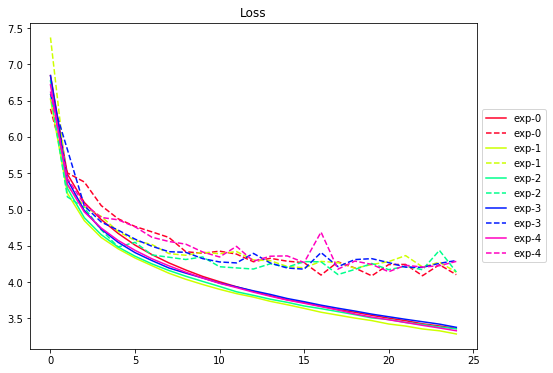

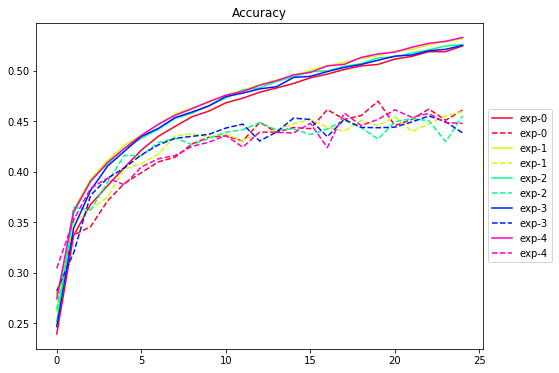

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()